Resumen:
    
En  este notebook hemos probado los siguientes modelos de detección de outliers con métodos supervisados y comparado los resultados con los outliers marcados en el dataset provisto. 

Se utilizó un Pipeline y GridSearch para pare procesar los datos y probar automáticamente un conjunto de hiperparámetros. Con los mejores hiperparámetros se obtuvieron los siguientes resultados.

   OneClassSVM - F1-Score: 0.129
   DecisionTreeClassifier obteniendo  - F1-Score: 0.769
   Isolation Forest - F1-Score: 0.222
    


In [34]:
#IMPORT

import numpy as np
print(f"{'numpy':<11} {np.__version__:<6}")

import pandas as pd
print(f"{'pandas':<11} {pd.__version__:<6}")

import matplotlib
print(f"{'matplotlib':<11} {matplotlib.__version__:<6}")

import matplotlib.pyplot as plt

from sklearn import __version__ as sklearn_version
print(f"{'sklearn':<11} {sklearn_version:<6}")

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, recall_score

import itertools

numpy       1.19.2
pandas      1.1.3 
matplotlib  3.3.2 
sklearn     0.23.2


In [35]:
#DIAGRAMA PARA PIPELINE
from sklearn import set_config
set_config(display="diagram")

In [36]:
#MÉTRICAS DE CONTROL
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

def print_report( Y_test, Y_preds ):
    print('MAE                                         : %.3f'% mean_absolute_error(Y_test, Y_preds))
    print('Precision                                   : %.3f'% precision_score(Y_test, Y_preds))
    print('Recall                                      : %.3f'% recall_score(Y_test, Y_preds))
    print('F1-Score                                    : %.3f'% f1_score(Y_test, Y_preds))
    print('\nPrecision Recall F1-Score Support Per Class : \n', precision_recall_fscore_support(Y_test, Y_preds))
    print('\nClassification Report                       : ')
    print(classification_report(Y_test, Y_preds))

In [37]:
# Model Evaluation - MATRIZ DE CONFUSION 
from sklearn.metrics import confusion_matrix

def confusion_matrix_plot( Y_test, Y_preds ):

    conf_mat = confusion_matrix(Y_test, Y_preds)
    print(conf_mat)
    with plt.style.context(('ggplot', 'seaborn')):
        fig = plt.figure(figsize=(6,6), num=1)
        plt.imshow(conf_mat, interpolation='nearest',cmap= plt.cm.Blues )
        plt.xticks([0,1],[0,1])
        plt.yticks([0,1],[0,1])
        plt.xlabel('Predicted Label')
        plt.ylabel('Actual Label')
        for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
                    plt.text(j, i,conf_mat[i, j], horizontalalignment="center",color="red")
        plt.grid(None)
        plt.title('Confusion Matrix')
        plt.colorbar()
        plt.show()

In [38]:
# Data Loading
path = "https://raw.githubusercontent.com/feliperichard/TP3/main/TP3_Intro_a_ML/datasets/traffic_AR_CL_UY%2Bfeatures%2Bcolumn_classifier.csv"

df0: pd.DataFrame = pd.read_csv(
    path,
    parse_dates=["Fecha"]
)

df0["Fecha"] = pd.to_datetime(df0["Fecha"], utc=True)


In [39]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7712 entries, 0 to 7711
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   Fecha                7712 non-null   datetime64[ns, UTC]
 1   Site                 7712 non-null   object             
 2   flow                 7712 non-null   object             
 3   Device               7712 non-null   object             
 4   Loading              7712 non-null   int64              
 5   Shipping             7712 non-null   int64              
 6   Payments             7712 non-null   int64              
 7   Review               7712 non-null   int64              
 8   Congrats             7712 non-null   int64              
 9   missing              7712 non-null   bool               
 10  day_of_week          7712 non-null   int64              
 11  month                7712 non-null   int64              
 12  year                

In [40]:
site   = "MLA"
flow   = "direct"
device = "Android"

result: pd.DataFrame = df0.query(
        f""" Site == "{site}" and flow == '{flow}' and Device == '{device}' """
    )


In [41]:
# Column / Feature Selection
data = result[["Fecha", "Site", "flow","Device","Loading","Shipping","Payments","Review","Congrats","TOTAL","anomaly"]]


In [42]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 4 to 7698
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   Fecha     488 non-null    datetime64[ns, UTC]
 1   Site      488 non-null    object             
 2   flow      488 non-null    object             
 3   Device    488 non-null    object             
 4   Loading   488 non-null    int64              
 5   Shipping  488 non-null    int64              
 6   Payments  488 non-null    int64              
 7   Review    488 non-null    int64              
 8   Congrats  488 non-null    int64              
 9   TOTAL     488 non-null    float64            
 10  anomaly   488 non-null    bool               
dtypes: bool(1), datetime64[ns, UTC](1), float64(1), int64(5), object(3)
memory usage: 42.4+ KB


False    0.893443
True     0.106557
Name: anomaly, dtype: float64


<AxesSubplot:title={'center':'Classes distribution'}>

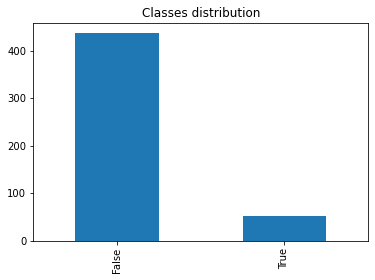

In [43]:
print(data.anomaly.value_counts(normalize=True))
data["anomaly"].value_counts().plot(kind="bar", title="Classes distribution")

In [44]:
map_class = { 
    True : 1,  # Anomalies on class 1
    False: -1  # Normal on class -1
}

data["class"] = data["anomaly"].map(map_class)

target_name = "class"
target = data[target_name]
target

<ipython-input-44-5dcc771d4818>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["class"] = data["anomaly"].map(map_class)


4       1
16     -1
28     -1
40     -1
52     -1
       ..
7626   -1
7644   -1
7662   -1
7680   -1
7698   -1
Name: class, Length: 488, dtype: int64

In [45]:
# We drop from our data the target column to train our 
data = data.drop( columns = [ target_name , "anomaly", "Fecha" ] )
data.head()

,Site,flow,Device,Loading,Shipping,Payments,Review,Congrats,TOTAL
4,MLA,direct,Android,160081,152310,124551,89380,83856,0.551
16,MLA,direct,Android,130042,122965,97941,65134,60631,0.493
28,MLA,direct,Android,113526,106599,83077,51557,47156,0.442
40,MLA,direct,Android,142338,133952,105604,67622,62339,0.465
52,MLA,direct,Android,159192,151029,119921,79137,73578,0.487


In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.15, random_state=999983)

#display(X_train)
 #display(y_train)

In [47]:
# define individual transformers in a pipeline
categorical_preprocessing = Pipeline([
    ('ohe', OneHotEncoder())#transforma las categoricas en numericas
])
numerical_preprocessing = Pipeline([
    ('imputation', SimpleImputer()),#nan, valores perdidos
    ('scaler', StandardScaler())#normaliza los valores
])

# define which transformer applies to which columns
preprocess = ColumnTransformer([
    ('categorical_preprocessing', categorical_preprocessing, ["Site", "flow","Device"]),
    ('numerical_preprocessing', numerical_preprocessing, ["Loading","Shipping","Payments","Review","Congrats","TOTAL"])
])

#SVM
# define clasifier
outliers_fraction = 0.09 

#CLASIFICADOR
#model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.02)
#**


model = OneClassSVM()

# create the final pipeline with preprocessing steps and 
# the final classifier step
#parameters = {#*
#'clf__kernel': ["poly", "rbf", "sigmoid"],#*
#        'clf__u': [0.01, 0.02, 0.05, 0.1, 0.5, 0.9],#*
#}


#classifier step
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('clf', model )
])
pipeline

#initialize
#grid_pipeline = GridSearchCV(pipeline, parameters, scoring="f1")

##**
#fit
#grid_pipeline.fit(X_train,y_train)
#grid_pipeline.best_params_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['Site', 'flow', 'Device']),
                                                 ('numerical_preprocessing',
                                                  Pipeline(steps=[('imputation',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Loading', 'Shipping',
                                                   'Payments', 'Review',
                                                   'Congrats', 'TOTAL'])])),
                ('clf', OneClassSVM())])

5512   -1
7352   -1
6040    1
5624   -1
6808   -1
       ..
3656   -1
2232   -1
408    -1
5528    1
6600   -1
Name: class, Length: 74, dtype: int64

array([-1, -1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1, -1,  1, -1,  1,
        1,  1,  1, -1,  1, -1, -1,  1,  1, -1,  1,  1,  1, -1, -1, -1,  1,
       -1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1, -1,  1,  1, -1,  1, -1,
       -1, -1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1, -1,
       -1,  1,  1,  1, -1, -1], dtype=int64)

[[35 31]
 [ 5  3]]


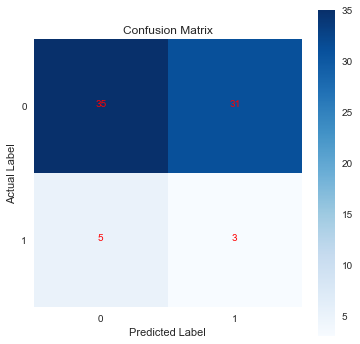

MAE                                         : 0.973
Precision                                   : 0.088
Recall                                      : 0.375
F1-Score                                    : 0.143

Precision Recall F1-Score Support Per Class : 
 (array([0.875     , 0.08823529]), array([0.53030303, 0.375     ]), array([0.66037736, 0.14285714]), array([66,  8], dtype=int64))

Classification Report                       : 
              precision    recall  f1-score   support

          -1       0.88      0.53      0.66        66
           1       0.09      0.38      0.14         8

    accuracy                           0.51        74
   macro avg       0.48      0.45      0.40        74
weighted avg       0.79      0.51      0.60        74



In [48]:
#Realizamos el ajuste
pipeline.fit(X_train,y_train)

# evaluate the model against test data
yhat = pipeline.predict(X_test) #clasifico

display(y_test)
display(yhat)

# evaluate predictions
confusion_matrix_plot(y_test, yhat)
print_report( y_test, yhat )
#


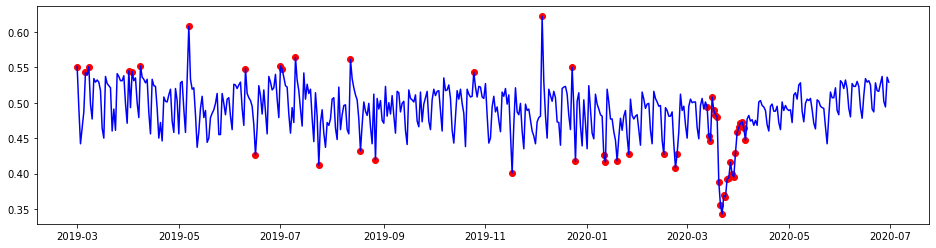

In [49]:
fig, ax = plt.subplots(figsize=(16,4))
a = result.loc[ result["anomaly"] == 1 , ["Fecha" , "TOTAL"] ] #anomaly

ax.plot(result["Fecha"], result["TOTAL"], color='blue')
ax.scatter(a["Fecha"],a["TOTAL"], color='red')

plt.show();

In [50]:
#MODELO OneClassSVM

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# define clasifier
model = OneClassSVM()

#classifier step
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('clf', model )
])

parameters = {
    'clf__kernel': ["poly", "rbf", "sigmoid"],
    'clf__nu': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.66, 0.68, 0.7, 0.8, 0.9, 0.95, 0.99],
    'clf__degree':[2,3,4],
    #'clf__gamma':["scale","auto"]
}
#display(pipeline.get_params().keys()) 

#initialize
grid_pipeline = GridSearchCV(pipeline, parameters, scoring="f1") 

grid_pipeline.fit(X_train,y_train)
grid_pipeline.best_params_

{'clf__degree': 4, 'clf__kernel': 'poly', 'clf__nu': 0.7}

In [55]:
results = grid_pipeline.cv_results_ 

df0 = pd.DataFrame(results)
df0.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__degree,param_clf__kernel,param_clf__nu,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
114,0.006791,0.000404,0.002983,0.000016,4,poly,0.7,"{'clf__degree': 4, 'clf__kernel': 'poly', 'clf...",0.333333,0.277778,0.250000,0.121212,0.324324,0.261330,0.076400,1
59,0.008376,0.001008,0.003799,0.000399,3,poly,0.6,"{'clf__degree': 3, 'clf__kernel': 'poly', 'clf...",0.333333,0.222222,0.318182,0.150000,0.272727,0.259293,0.067007,2
58,0.007573,0.000501,0.003990,0.000620,3,poly,0.5,"{'clf__degree': 3, 'clf__kernel': 'poly', 'clf...",0.292683,0.280702,0.352941,0.125000,0.210526,0.252370,0.078123,3
113,0.007486,0.001204,0.003199,0.000396,4,poly,0.68,"{'clf__degree': 4, 'clf__kernel': 'poly', 'clf...",0.312500,0.277778,0.235294,0.111111,0.324324,0.252201,0.077051,4
7,0.006979,0.000004,0.003187,0.000381,2,poly,0.5,"{'clf__degree': 2, 'clf__kernel': 'poly', 'clf...",0.292683,0.271186,0.320000,0.127660,0.245614,0.251429,0.066554,5


[[45 21]
 [ 6  2]]


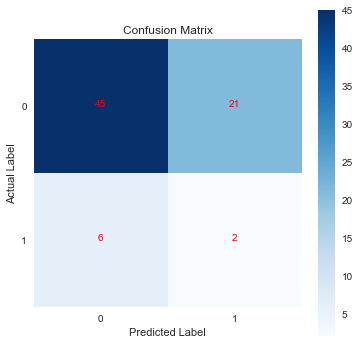

MAE                                         : 0.730
Precision                                   : 0.087
Recall                                      : 0.250
F1-Score                                    : 0.129

Precision Recall F1-Score Support Per Class : 
 (array([0.88235294, 0.08695652]), array([0.68181818, 0.25      ]), array([0.76923077, 0.12903226]), array([66,  8], dtype=int64))

Classification Report                       : 
              precision    recall  f1-score   support

          -1       0.88      0.68      0.77        66
           1       0.09      0.25      0.13         8

    accuracy                           0.64        74
   macro avg       0.48      0.47      0.45        74
weighted avg       0.80      0.64      0.70        74



In [58]:
model = OneClassSVM(degree = 4, kernel="poly", nu=0.7)
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('clf', model )
])
grid_pipeline.fit(X_train,y_train)
yhat = grid_pipeline.predict(X_test)

# evaluate predictions
confusion_matrix_plot(y_test, yhat)
print_report( y_test, yhat )

[[39 27]
 [ 6  2]]


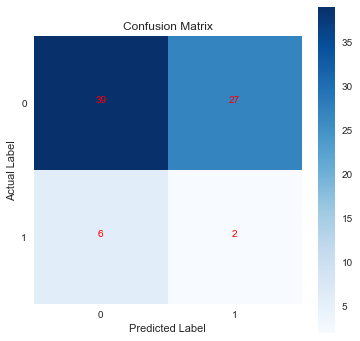

MAE                                         : 0.892
Precision                                   : 0.069
Recall                                      : 0.250
F1-Score                                    : 0.108

Precision Recall F1-Score Support Per Class : 
 (array([0.86666667, 0.06896552]), array([0.59090909, 0.25      ]), array([0.7027027 , 0.10810811]), array([66,  8], dtype=int64))

Classification Report                       : 
              precision    recall  f1-score   support

          -1       0.87      0.59      0.70        66
           1       0.07      0.25      0.11         8

    accuracy                           0.55        74
   macro avg       0.47      0.42      0.41        74
weighted avg       0.78      0.55      0.64        74



In [53]:
model = OneClassSVM(kernel="poly", nu=0.6)
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('clf', model )
])
grid_pipeline.fit(X_train,y_train)
yhat = grid_pipeline.predict(X_test)

# evaluate predictions
confusion_matrix_plot(y_test, yhat)
print_report( y_test, yhat )

In [ ]:
#MODELO DecisionTreeClassifier

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# define clasifier
model2 = DecisionTreeClassifier()

#classifier step
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('clf', model2 )
])

parameters = {
    'clf__criterion': ["gini", "entropy"],
    'clf__splitter': ["best", "random"],
    'clf__max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'clf__random_state':[1, 42],
}

#DecisionTreeClassifier(max_leaf_nodes=None, random_state=0)

#display(pipeline.get_params().keys()) 

#initialize
grid_pipeline = GridSearchCV(pipeline, parameters, scoring="f1") 

grid_pipeline.fit(X_train,y_train)
grid_pipeline.best_params_


{'clf__criterion': 'gini',
 'clf__max_depth': 4,
 'clf__random_state': 1,
 'clf__splitter': 'best'}

[[66  0]
 [ 3  5]]


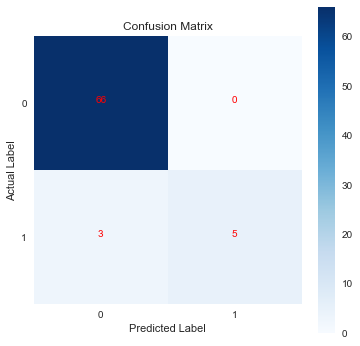

MAE                                         : 0.081
Precision                                   : 1.000
Recall                                      : 0.625
F1-Score                                    : 0.769

Precision Recall F1-Score Support Per Class : 
 (array([0.95652174, 1.        ]), array([1.   , 0.625]), array([0.97777778, 0.76923077]), array([66,  8], dtype=int64))

Classification Report                       : 
              precision    recall  f1-score   support

          -1       0.96      1.00      0.98        66
           1       1.00      0.62      0.77         8

    accuracy                           0.96        74
   macro avg       0.98      0.81      0.87        74
weighted avg       0.96      0.96      0.96        74



In [110]:
model = DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=1, splitter='best')
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('clf', model )
])
grid_pipeline.fit(X_train,y_train)
yhat = grid_pipeline.predict(X_test)

# evaluate predictions
confusion_matrix_plot(y_test, yhat)
print_report( y_test, yhat )

In [34]:
# Isolation Forest

In [86]:
# define clasifier
from sklearn.ensemble import IsolationForest
model3 = IsolationForest()

#classifier step
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('clf', model3 )
])

parameters = {
    'clf__max_samples': [2,4,6,10],
    'clf__random_state':[42]
    
}


#display(pipeline.get_params().keys()) 

#initialize
grid_pipeline = GridSearchCV(pipeline, parameters, scoring="f1") 

grid_pipeline.fit(X_train,y_train)
grid_pipeline.best_params_


{'clf__max_samples': 4, 'clf__random_state': 42}

[[10 56]
 [ 0  8]]


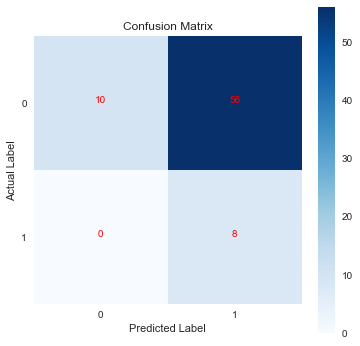

MAE                                         : 1.514
Precision                                   : 0.125
Recall                                      : 1.000
F1-Score                                    : 0.222

Precision Recall F1-Score Support Per Class : 
 (array([1.   , 0.125]), array([0.15151515, 1.        ]), array([0.26315789, 0.22222222]), array([66,  8], dtype=int64))

Classification Report                       : 
              precision    recall  f1-score   support

          -1       1.00      0.15      0.26        66
           1       0.12      1.00      0.22         8

    accuracy                           0.24        74
   macro avg       0.56      0.58      0.24        74
weighted avg       0.91      0.24      0.26        74



In [87]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(max_samples=4, random_state=42)
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('clf', model )
])
grid_pipeline.fit(X_train,y_train)
yhat = grid_pipeline.predict(X_test)

# evaluate predictions
confusion_matrix_plot(y_test, yhat)
print_report( y_test, yhat )